<a href="https://colab.research.google.com/github/cderamond/mba_UTFSM_finanzas/blob/caso_final/casoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 2 (50 puntos)

Descargar desde https://finance.yahoo.com/ los precios históricos mensuales de
10 acciones (marzo 2011 a marzo 2022). Las acciones deben ser (transarse) en
Estados Unidos y como máximo 3 acciones deben corresponder al mismo sector
industrial. A partir de los datos mensuales, las estadísticas de cada acción y la correlación entre cada par de ellas:



### Preparación y cálculos

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install PyPortfolioOpt

In [100]:
# setting environment
import numpy as np
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import seaborn as sns

In [4]:
# bajar stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'KO', 'AMZN', 'GM', 'F', 'BRK-B', 'DIS']
start_date = '2011-03-01'
end_date = '2022-03-30'

# bajamos la data de todas las acciones
data = yf.download(tickers, start_date, end_date, group_by='ticker')
# ahora las del SP500, VOO ETF como benchmark
sp= yf.download('VOO', start_date, end_date, group_by='ticker')

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [95]:
# filtrar los datos
dataadj = data.loc[:,(slice(None),'Adj Close')]
# revisar la estructura de datos
dataadj.dtypes

GM     Adj Close    float64
AMZN   Adj Close    float64
BRK-B  Adj Close    float64
F      Adj Close    float64
TSLA   Adj Close    float64
KO     Adj Close    float64
AAPL   Adj Close    float64
GOOGL  Adj Close    float64
DIS    Adj Close    float64
MSFT   Adj Close    float64
dtype: object

In [96]:
# cambio porcentual
dataadj = (dataadj.pct_change()
            .dropna()
            )
dataadj

,GM,AMZN,BRK-B,F,TSLA,KO,AAPL,GOOGL,DIS,MSFT
,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
Date,,,,,,,,,,
2011-03-02,-0.002124,0.015227,-0.002698,0.000000,0.003342,-0.007395,0.008044,0.000050,0.006978,-0.003058
2011-03-03,0.004562,0.004476,0.019760,0.006821,0.014155,0.017694,0.021129,0.014597,0.018018,0.004601
2011-03-04,-0.019376,-0.006482,-0.013841,-0.023035,0.024220,-0.005490,0.001224,-0.014666,-0.011799,-0.009542
2011-03-07,-0.021303,-0.015087,-0.005380,-0.028433,-0.000401,0.000153,-0.012889,-0.014918,-0.012170,-0.008863
2011-03-08,0.032177,-0.012952,0.015404,0.032834,-0.011227,0.006440,0.001125,0.001099,0.004184,0.007387
...,...,...,...,...,...,...,...,...,...,...
2022-03-23,-0.017505,-0.008982,-0.005058,-0.023991,0.005161,-0.006579,0.008234,-0.011386,-0.017629,-0.015030
2022-03-24,0.013020,0.001478,0.012092,0.008993,0.014823,0.009603,0.022678,0.023840,0.009590,0.015393


### Representaciones gráficas

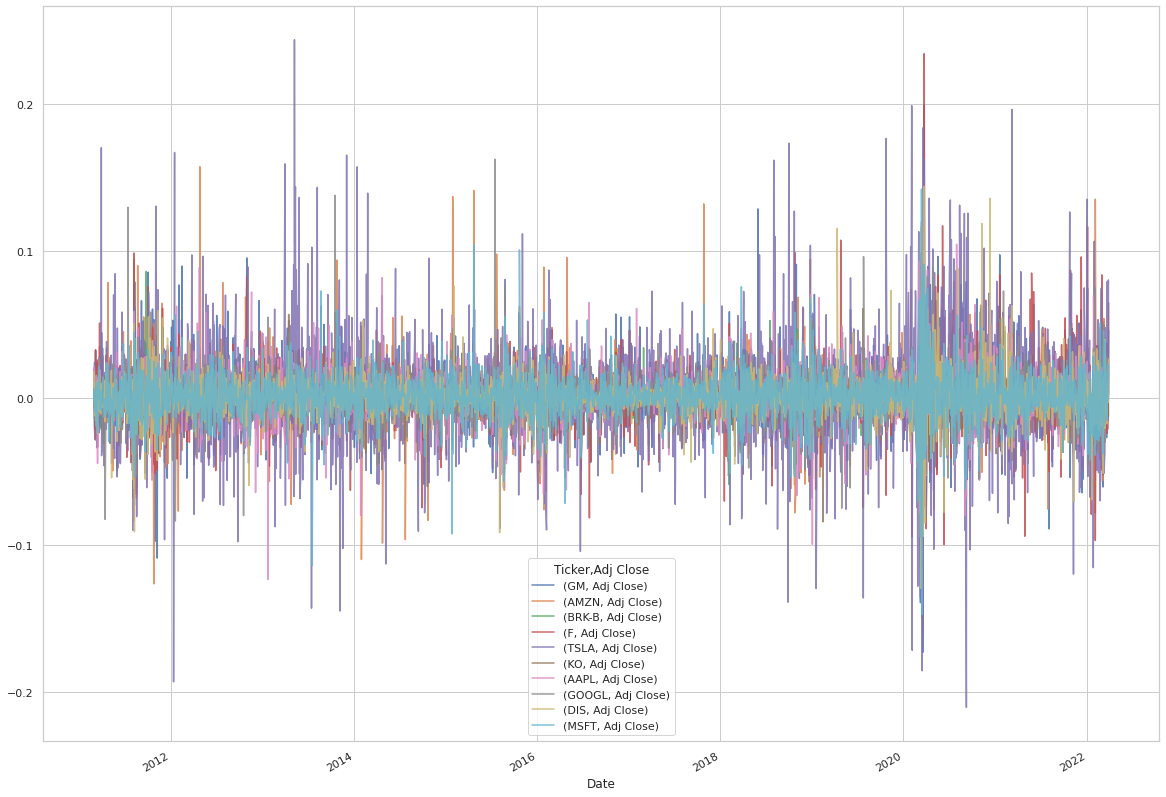

In [132]:
# gráfica de rentabilidades
dataadj.plot(figsize=(20,15), alpha=.85)

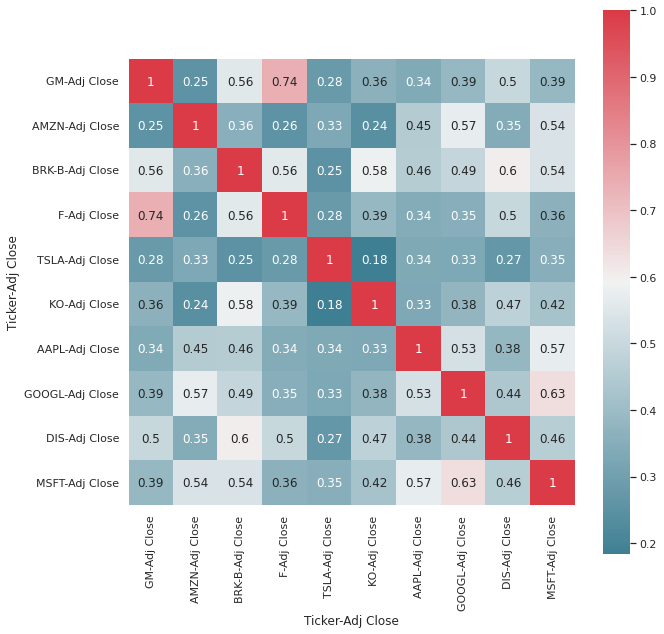

In [141]:
# representación matriz de correlaciones
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(dataadj.corr(), annot=True, 
            mask=np.zeros_like(dataadj.corr(), dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True,
            )

A destacar:
* Alta correlación entre Ford [F](https://g.co/finance/F:NYSE)
y [GM](https://www.google.com/finance/quote/gm:nyse)
, sin embargo, vemos que Tesla [$TSLA](https://www.google.com/finance/quote/tsla:nasdaq) es prácticamente no relacionada.
* [MSFT](https://www.google.com/finance/quote/MSFT:NASDAQ) y  [GOOGL](https://www.google.com/finance/quote/GOOGL:NASDAQ) también presentan una relación destacable.

### Análisis varianza

In [143]:
dataadj.describe()

Ticker,GM,AMZN,BRK-B,F,TSLA,KO,AAPL,GOOGL,DIS,MSFT
Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
count,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000,2789.000000
mean,0.000444,0.001270,0.000588,0.000405,0.002562,0.000420,0.001170,0.000940,0.000601,0.001107
std,0.021437,0.019849,0.012382,0.020408,0.035107,0.011098,0.017825,0.016355,0.015916,0.016118
min,-0.173228,-0.126568,-0.095921,-0.110124,-0.210628,-0.096725,-0.128647,-0.116342,-0.129846,-0.147390
25%,-0.010139,-0.008354,-0.005450,-0.009428,-0.014672,-0.004505,-0.007308,-0.006568,-0.006449,-0.006560
50%,0.000282,0.001102,0.000481,0.000000,0.001267,0.000487,0.000888,0.000931,0.000610,0.000695
75%,0.010629,0.011283,0.006557,0.009944,0.019081,0.005909,0.010454,0.008950,0.007806,0.009048
max,0.199432,0.157457,0.116099,0.234414,0.243951,0.064796,0.119808,0.162584,0.144123,0.142169


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ca01e1d90>,
      dtype=object)

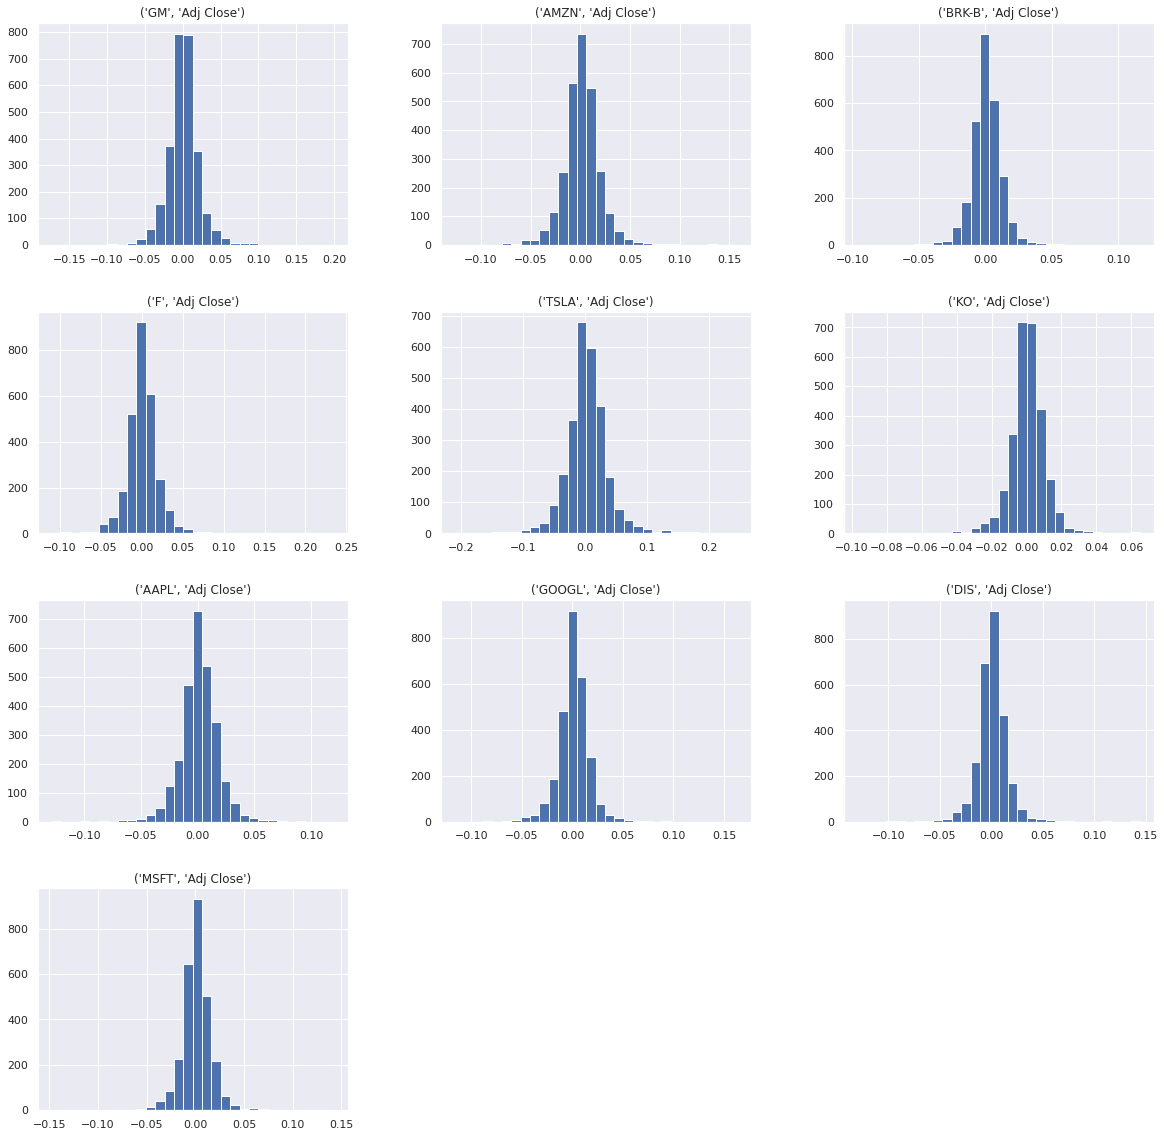

In [148]:
dataadj.hist(bins=30, figsize=(20, 20))

## A) Describa los principales negocios, riesgos e industria a la que pertenece.



Industria seleccionada: **Automotriz** 
*   Tesla $TSLA

*   General Motors $GM

*   Ford $F

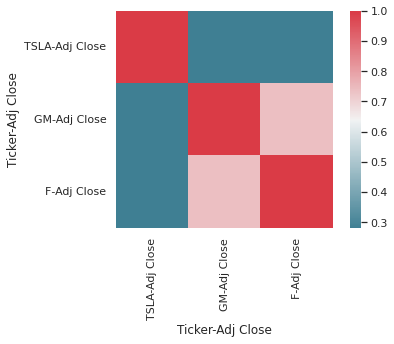

In [138]:
auto = dataadj.loc[:, (['TSLA', 'GM', 'F'], slice(None))]
sns.heatmap(auto.corr(), mask=np.zeros_like(auto.corr(), dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)

### 

## B) Determine la rentabilidad y riesgo del portafolio invirtiendo 10% en cada acción.

## C) Determine el portafolio de mínima varianza.

## D) Determine el portafolio óptimo Sharpe (determine Rf según el mercado seleccionado y justifique el valor calculado).


## E) Determine la frontera eficiente de riesgo retorno (10 puntos al menos) e identifique en el gráfico los resultados obtenidos de las letras B), C) y D). Comente.